<a href="https://colab.research.google.com/github/n-west/seti-tutorials/blob/main/turboseti_on_voyager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Voyager 1 turboSETI walk-through

## Introduction

The goal of this walkthrough is to step through the turboSETI pipeline. It uses data collected by [Breakthrough Listen](https://en.wikipedia.org/wiki/Breakthrough_Listen) at the [Green Bank Telescope (GBT)](https://en.wikipedia.org/wiki/Green_Bank_Telescope). The data used in this walk-through consists of 6 files in hdf5 format with a schema regularly used by Breakthrough Listen:

1. a recording from GBT pointing at voyager 1 (direction A)
2. a recording from GBT pointing slightly off voyager 1 (direction B)
3. a recording from GBT pointing at voyager 1 (direction A)
4. a recording from GBT pointing slightly off voyager 1 (direction C)
5. a recording from GBT pointing at voyager 1 (direction A)
6. a recording from GBT pointing slightly off voyager 1 (direction D)

This pattern of looking at a potential source, looking away is known as blinking and is typically repeated 3 times with the off direction being different each time to form an ABACAD cadence. The motivation is to reliably observe a source in the 3 on-target observations and not see the source in the 3 off-target observations. If a signal is always present we assume it's from earth rather than the sky direction.

References:
* First iteration of this tutorial: https://github.com/UCBerkeleySETI/breakthrough/blob/master/GBT/voyager/voyager.ipynb
* Most recent iteration of this tutorial I used: https://github.com/elanlavie/VoyagerTutorialRepository/blob/master/VoyagerTutorial.ipynb
* "**A 1.1-1.9GHz Survey of the Kepler Field. A search for narrow-band emission from select targets**" (the first use of taylor tree search for narrowband SETI search) https://articles.adsabs.harvard.edu/pdf/1974A%26AS...15..367T
* "**A sensitive method for detecting dispersed radio emission**" (the introduction of the taylor tree search method) https://iopscience.iop.org/article/10.1088/0004-637X/767/1/94/pdf


## Setup environment

In [1]:
## Setup -- install
# * blimpy - file utils
# * turbo_seti - dedoppler search with taylor tree
# * tqdm - progress bar
# * requests - fetch http (download data files)
!pip install git+https://github.com/UCBerkeleySETI/blimpy \
             git+https://github.com/UCBerkeleySETI/turbo_seti \
             tqdm \
             requests


  Cloning https://github.com/UCBerkeleySETI/blimpy to /tmp/pip-req-build-cz_vzfea
  Running command git clone --filter=blob:none --quiet https://github.com/UCBerkeleySETI/blimpy /tmp/pip-req-build-cz_vzfea
  Resolved https://github.com/UCBerkeleySETI/blimpy to commit 3ebf04342227a95405aa32e5bc75832d1dd17f28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/UCBerkeleySETI/turbo_seti to /tmp/pip-req-build-brj36geo
  Running command git clone --filter=blob:none --quiet https://github.com/UCBerkeleySETI/turbo_seti /tmp/pip-req-build-brj36geo
  Resolved https://github.com/UCBerkeleySETI/turbo_seti to commit 7d9b4fde9bc98d834dc11cfc0acd2380e6676f0e
  Preparing metadata (setup.py) ... done


In [2]:
## Download files - this function is boilerplate and just a nicety around downloading files
# from the BL open data archive at UC Berkeley
# http://seti.berkeley.edu/opendata

import os

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
import requests

def download_file_with_progress_bar(url, filename=None, download_dir=os.curdir, mkdir=True, redownload=False):
    # From https://stackoverflow.com/a/37573701/4228052

    # Use the filename from the end of the URL by default
    if filename is None:
        filename = os.path.basename(url)

    # Make sure the download directory exists
    if not os.path.exists(download_dir):
        if mkdir:
            os.makedirs(download_dir)
        else:
            raise FileNotFoundError("Download directory '{}' does not exist, and `mkdir` option is disabled.".format(download_dir))
    elif not os.path.isdir(download_dir):
        raise NotADirectoryError("Download directory '{}' exists, but is not actually a directory!".format(download_dir))

    download_path = os.path.join(download_dir, filename)
    None


    if os.path.exists(download_path) and not redownload:
        print("File '{}' already exists - not re-downloading {}".format(download_path, url))
        return

    # Streaming, so we can iterate over the response.
    response = requests.get(url, stream=True)
    # Quit early if there's an error
    try:
        response.raise_for_status()
    except requests.exceptions.HTTPError as e:
        raise requests.exceptions.HTTPError("Failed to download {} to {}".format(url, download_path)) from e

    # Create the progress bar
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    try:
        progress_bar = tqdm_notebook(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=download_path)
    except ImportError:
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=download_path, mininterval=5)

    # Write the file
    with open(download_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    # Make sure the download completed
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        progress_bar.clear()
        raise ValueError("Unexpected error: failed to completely download {}".format(url))

    progress_bar.close()
    return response



## Download the data

The following cell has a list of 6 files we'll download. It downloads them with a progress bar to the `"voyager_2020_data"` directory and builds a list with the path of each file. Each file is about 50MB

In [3]:
data_urls = ["http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5",
              "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5",
              "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5",
              "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5",
              "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5",
              "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5"]

# Store data here
data_directory = 'voyager_2020_data/'

# Download each one into a directory called 'data' if they aren't already present.
for url in data_urls:
    download_file_with_progress_bar(url, download_dir=data_directory)

# Get a list of all the files we downloaded
data_files = filter(lambda f: f.endswith(".h5"), [data_directory + f for f in os.listdir(data_directory)])
data_files = list(data_files)
print(data_files)


File 'voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5
File 'voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5
File 'voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5
File 'voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5' already exists - not re-downloading http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_gu

## Inspect the data (skip this if you just want to run the pipeline)

This inspects the data with blimpy and shows some details of the hdf5 files. Blimpy tools know

In [4]:
## Inspect the h5 file
import h5py
f = h5py.File(data_files[0], 'r')

print(f.keys())

print(f["data"])
print(f["mask"])


<KeysViewHDF5 ['data', 'mask']>
<HDF5 dataset "data": shape (16, 1, 1048576), type "<f4">
<HDF5 dataset "mask": shape (16, 1, 1048576), type "|u1">


extracting integration 0...


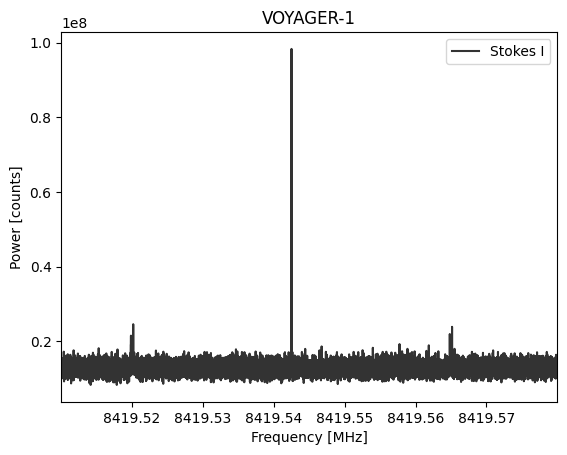

Waterfall data: voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5

In [5]:
import pylab as plt
from blimpy import Waterfall
%matplotlib inline

f_start = 8419.51
f_stop = 8419.58

obs = Waterfall(data_files[0], f_start, f_stop)
obs.plot_spectrum(f_start=f_start, f_stop=f_stop)
plt.show()

obs

In [6]:
from pprint import pprint
pprint(obs.header)
print(obs.data.shape)

{'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object),
 'az_start': 0.0,
 'data_type': 1,
 'fch1': 8421.38671875,
 'foff': -2.7939677238464355e-06,
 'machine_id': 20,
 'nbits': 32,
 'nchans': 1048576,
 'nifs': 1,
 'source_name': 'VOYAGER-1',
 'src_dej': <Angle 12.40379333 deg>,
 'src_raj': <Angle 17.211245 hourangle>,
 'telescope_id': 6,
 'tsamp': 18.253611007999982,
 'tstart': 59046.933703703704,
 'za_start': 0.0}
(16, 1, 25054)


Showing spectrum for file 0: voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5
extracting integration 0...


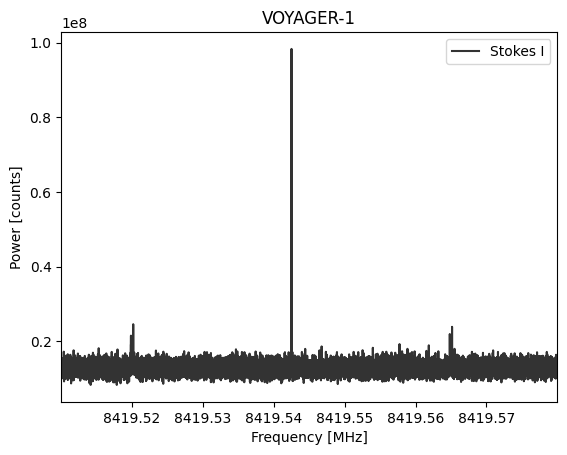

Showing spectrum for file 1: voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5
extracting integration 0...


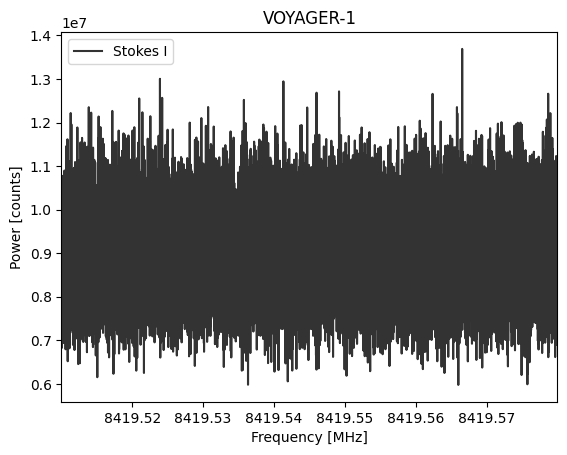

Showing spectrum for file 2: voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5
extracting integration 0...


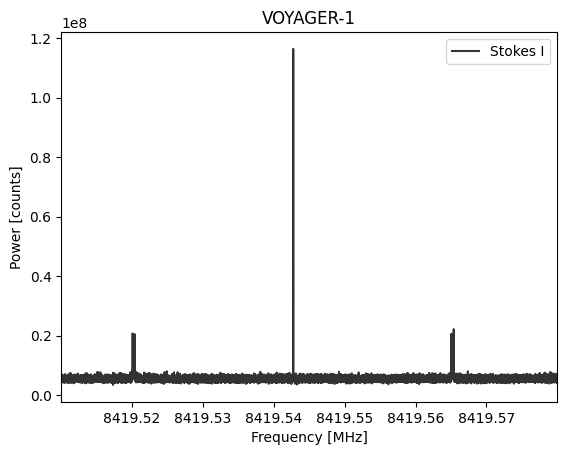

Showing spectrum for file 3: voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5
extracting integration 0...


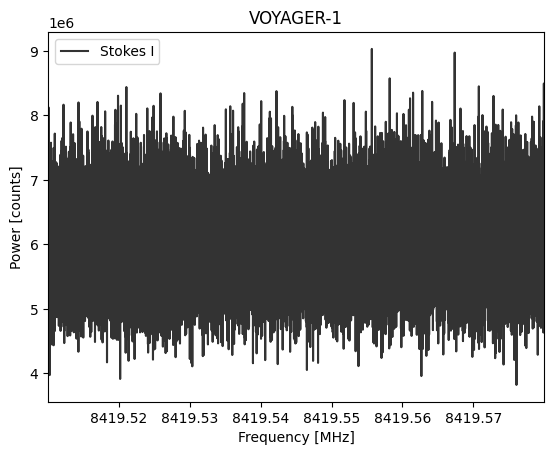

Showing spectrum for file 4: voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5
extracting integration 0...


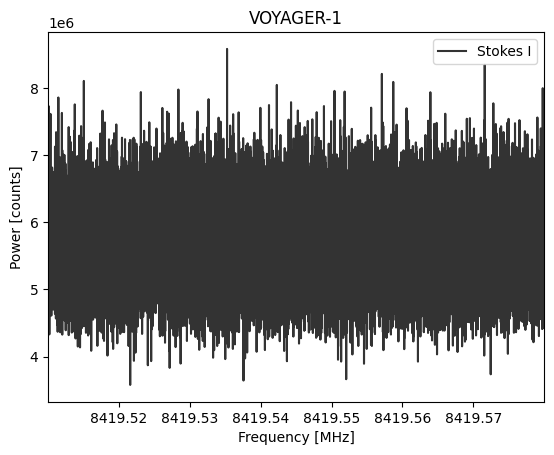

Showing spectrum for file 5: voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5
extracting integration 0...


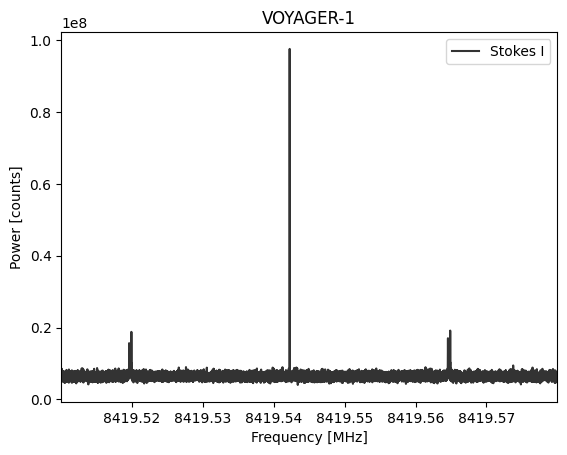

In [7]:
import pylab as plt
from blimpy import Waterfall
%matplotlib inline

f_start = 8419.51
f_stop = 8419.58

for ind, file_path in enumerate(data_files):
  print(f"Showing spectrum for file {ind}: {file_path}")
  obs = Waterfall(file_path, f_start, f_stop)
  obs.plot_spectrum(f_start=f_start, f_stop=f_stop)
  plt.show()

The

# Turboseti

The turboseti pipeline will run the Taylor Tree Search to find signals with drifting doppler. This is effectively a computationally efficient (but incoherent) method of identifying energy in a single channel of our data that changes frequency within certain ranges.

The process with turboseti is to run `FindDoppler`, then the `find_event_pipeline` function.

`FindDoppler` identifies "hits", which occur when the SNR of doppler drifting energy exceeds a threshold. The maximum drift rate we'll use for voyager 1 search is 4 Hz/sec and a threshold of 10. This creates files with ".dat" extension that are text files with info on drift rate, SNR, and location of the hit.

`find_event_pipeline` searches through a list of hits to determine if a hit occurs in a sufficient number of ON target observations but not the OFF target observations.

* `filter_threshold` = 1: **hits** that meet the SNR/drift criteria but no ON/OFF check
* `filter_threshold` = 2: report **events** where a signal is in at least one ON observation and not present in all three OFF observations
* `filter_threshold` = 3: report **events** where a signal is in all three ON observations and not present in all three OFF observations.

## FindDoppler (find "hits")

In [8]:
from turbo_seti.find_doppler.find_doppler import FindDoppler


In [9]:

hits_dir = "voyager_2020_data/"
for data_file in data_files:
    doppler = FindDoppler(data_file,
                      max_drift = 4, # Max drift rate = 4 Hz/second
                      snr = 10,      # Minimum signal to noise ratio = 10:1
                      out_dir = hits_dir # This is where the turboSETI output files will be stored.
                     )
    doppler.search()

print('\n===== All DAT files have been computed and a list of them has been constructed\n')


turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.3
HDF5 library version 1.12.2




INFO:find_doppler.0:Spectra 0 1st 3 values: [5880825.  5606774.5 7201990. ]
INFO:find_doppler.0:Spectra 1 1st 3 values: [5208161.  5433646.5 5460422.5]


HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40379333 deg>, 'src_raj': <Angle 17.211245 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.933703703704, 'za_start': 0.0}

Starting ET search with parameters: datafile=voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=voyager_2020_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr': 0.0, 'pulsar_stats': array([0., 0., 0., 0., 0., 0.]), 'RFI_level': 0.0, 'Mean_SEFD': 0.0, 'psrflux_Sens': 0.0, 'SEFDs_val'

INFO:find_doppler.0:Top hit found! SNR 10.996549, Drift Rate -0.408170, index 651964
INFO:find_doppler.0:Top hit found! SNR 82.802612, Drift Rate -0.387762, index 660074
INFO:find_doppler.0:Top hit found! SNR 10.476917, Drift Rate -0.377557, index 668184
INFO:find_doppler.0:Spectra 0 1st 3 values: [4233161.5 4866011.5 4252712.5]
INFO:find_doppler.0:Spectra 1 1st 3 values: [4741422.5 4620766.  4691866.5]



turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.3
HDF5 library version 1.12.2


HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40376944 deg>, 'src_raj': <Angle 17.27950361 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.937372685185, 'za_start': 0.0}

Starting ET search with parameters: datafile=voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=voyager_2020_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr':

INFO:find_doppler.0:Spectra 0 1st 3 values: [2995706.  2707467.5 2586438.8]
INFO:find_doppler.0:Spectra 1 1st 3 values: [2392047.5 2505239.  2590622.5]



turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.3
HDF5 library version 1.12.2


HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40378167 deg>, 'src_raj': <Angle 17.21124472 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.92634259259, 'za_start': 0.0}

Starting ET search with parameters: datafile=voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=voyager_2020_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr': 

INFO:find_doppler.0:Top hit found! SNR 22.329107, Drift Rate -0.367353, index 651879
INFO:find_doppler.0:Top hit found! SNR 192.895111, Drift Rate -0.357149, index 659989
INFO:find_doppler.0:Top hit found! SNR 22.572433, Drift Rate -0.367353, index 667983
INFO:find_doppler.0:Spectra 0 1st 3 values: [3152164.8 2917681.8 2709741. ]
INFO:find_doppler.0:Spectra 1 1st 3 values: [3064531.5 3476725.8 2935090.2]



turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.3
HDF5 library version 1.12.2


HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 13.40378444 deg>, 'src_raj': <Angle 17.211245 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.93002314815, 'za_start': 0.0}

Starting ET search with parameters: datafile=voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=voyager_2020_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr': 0.

INFO:find_doppler.0:Spectra 0 1st 3 values: [3193343.8 2054488.8 2877254.2]
INFO:find_doppler.0:Spectra 1 1st 3 values: [3471901.8 2847157.5 2962188. ]



turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.3
HDF5 library version 1.12.2


HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 11.40377306 deg>, 'src_raj': <Angle 17.21124389 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.944768518515, 'za_start': 0.0}

Starting ET search with parameters: datafile=voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=voyager_2020_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr':

INFO:find_doppler.0:Spectra 0 1st 3 values: [2835156.  2706873.2 3367498.5]
INFO:find_doppler.0:Spectra 1 1st 3 values: [3646120.8 3037369.  3306062.8]



turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 3.8.0
hdf5plugin version 4.1.3
HDF5 library version 1.12.2


HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40378 deg>, 'src_raj': <Angle 17.21124361 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.941087962965, 'za_start': 0.0}

Starting ET search with parameters: datafile=voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=voyager_2020_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr': 0.

INFO:find_doppler.0:Top hit found! SNR 18.529829, Drift Rate -0.418374, index 652058
INFO:find_doppler.0:Top hit found! SNR 145.126450, Drift Rate -0.438783, index 660166
INFO:find_doppler.0:Top hit found! SNR 19.028582, Drift Rate -0.418374, index 668162



===== All DAT files have been computed and a list of them has been constructed



In [10]:
# Get a list of all the dat files containing hits (results of `find_doppler1)
hits_files = filter(lambda f: f.endswith(".dat"), [hits_dir + f for f in os.listdir(hits_dir)])
hits_files = list(hits_files)
print(hits_files)

# This writes the .dat files into a .lst, as required by the find_event_pipeline:
hits_list_path = os.path.join(hits_dir, 'hits_files.lst')
with open(hits_list_path, 'w') as f:
    for hits_path in hits_files:
        f.write(f"{hits_path}\n")

['voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat', 'voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.dat', 'voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.dat', 'voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat', 'voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat', 'voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.dat']


## Find events (check if hits form events)


In [11]:
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline


csvf_path = os.path.join(hits_dir, 'found_event_table.csv')
find_event_pipeline(hits_list_path,
                    filter_threshold = 3,
                    number_in_cadence = len(hits_files),
                    csv_name=csvf_path,
                    saving=True)

INFO:find_event_pipeline:file=single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat, tstart=59046.92634259259, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
INFO:find_event_pipeline:file=single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat, tstart=59046.93002314815, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
INFO:find_event_pipeline:file=single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat, tstart=59046.933703703704, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
INFO:find_event_pipeline:file=single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.dat, tstart=59046.937372685185, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
INFO:find_event_pipeline:file=single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.dat, tstart=59046.941087962965, source_name=VOY


===========   BEGINNING FIND_EVENT PIPELINE   ===========

Assuming the first observation is an ON
There are 6 total files in the filelist voyager_2020_data/hits_files.lst
Therefore, looking for events in 1 on-off set(s)
Present in all ON sources with RFI rejection from the OFF sources
A CSV file will be saved
=== First DAT file in set:  single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat ===
find_events: SNR_cut = None
find_events: min_drift_rate = None
find_events: max_drift_rate = None
find_events: Loading data...
find_events: Loaded 3 hits from voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat (ON)
find_events: Loaded 0 hits from voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat (OFF)
find_events: Loaded 3 hits from voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat (ON)
find_events: Loaded 0 hits from voyager_2020_data/single_coarse_guppi_59046_80989_DIAG

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,1,-0.367353,22.329107,8419.565390,651879,8419.567580,8419.563202,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_0,on_table_1,2,0,0.0
1,2,-0.357149,192.895111,8419.542731,659989,8419.544921,8419.540543,0,21991,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_1,on_table_1,2,0,0.0


In [12]:
# This writes the .h5 files into a .lst, as required by the plot_event_pipeline:
h5_list_path = os.path.join(data_directory, 'data_files.lst')
with open(h5_list_path, 'w') as f:
    for h5_path in data_files:
        f.write(h5_path + '\n')


In [13]:

from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline
# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(h5_list_path, 'r') as f:
    print(f.read())

# and finally we plot
plot_event_pipeline(csvf_path, # full path of the CSV file built by find_event_pipeline()
                    h5_list_path, # full path of text file containing the list of .h5 files
                    filter_spec="3", # filter threshold
                    user_validation=False) # Non-interactive

voyager_2020_data/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5
voyager_2020_data/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5
voyager_2020_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5
voyager_2020_data/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5
voyager_2020_data/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5
voyager_2020_data/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5

plot_event_pipeline: Opened file voyager_2020_data/found_event_table.csv
plot_event_pipeline: file = single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, tstart = 59046.92634259259, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5, tstart = 59046.93002314815, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5, tstart = 59046.

INFO:plot_event:plot_candidate_events: elapsed time = 2.70 seconds


## Visualize events

In [14]:
import PIL
from PIL import Image


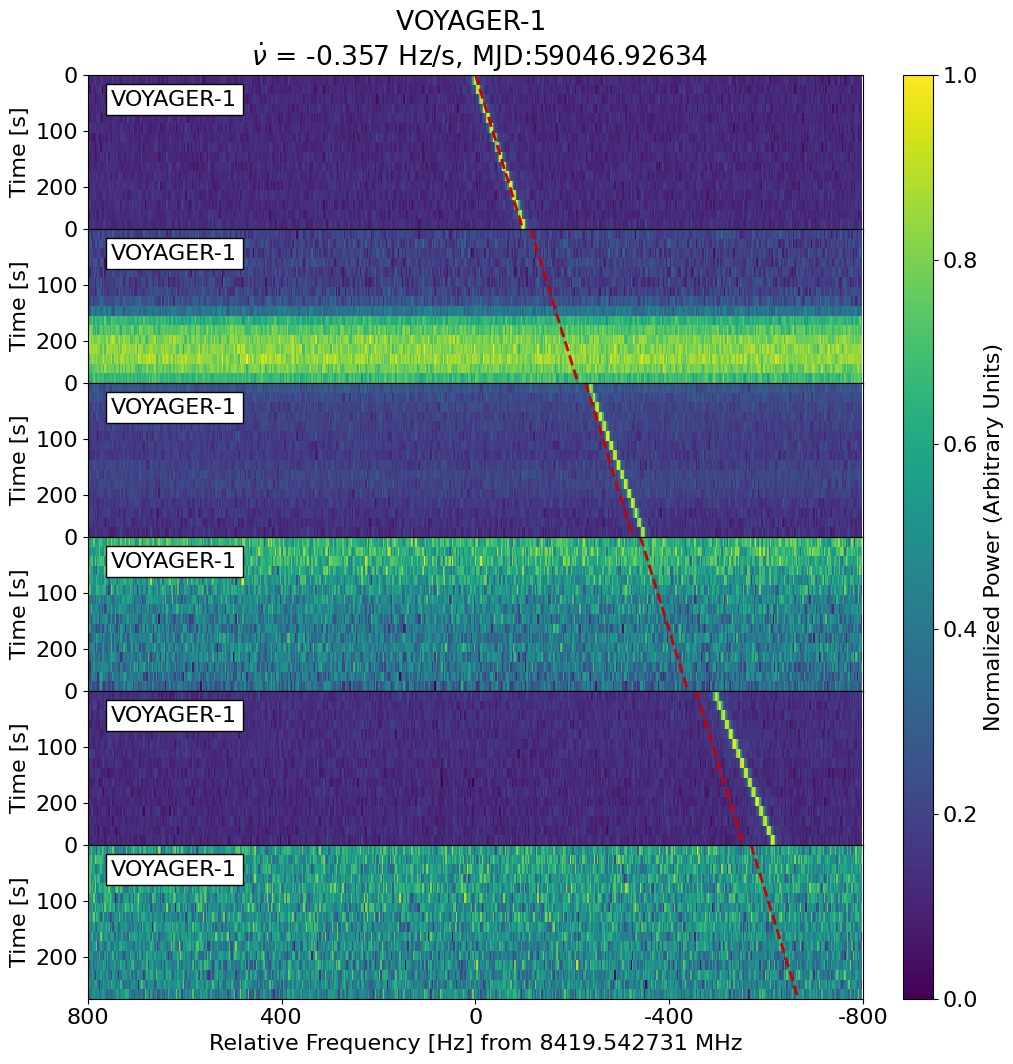

In [15]:

event1 = Image.open("voyager_2020_data/3_VOYAGER-1_dr_-0.36_freq_8419.541931.png")
event1

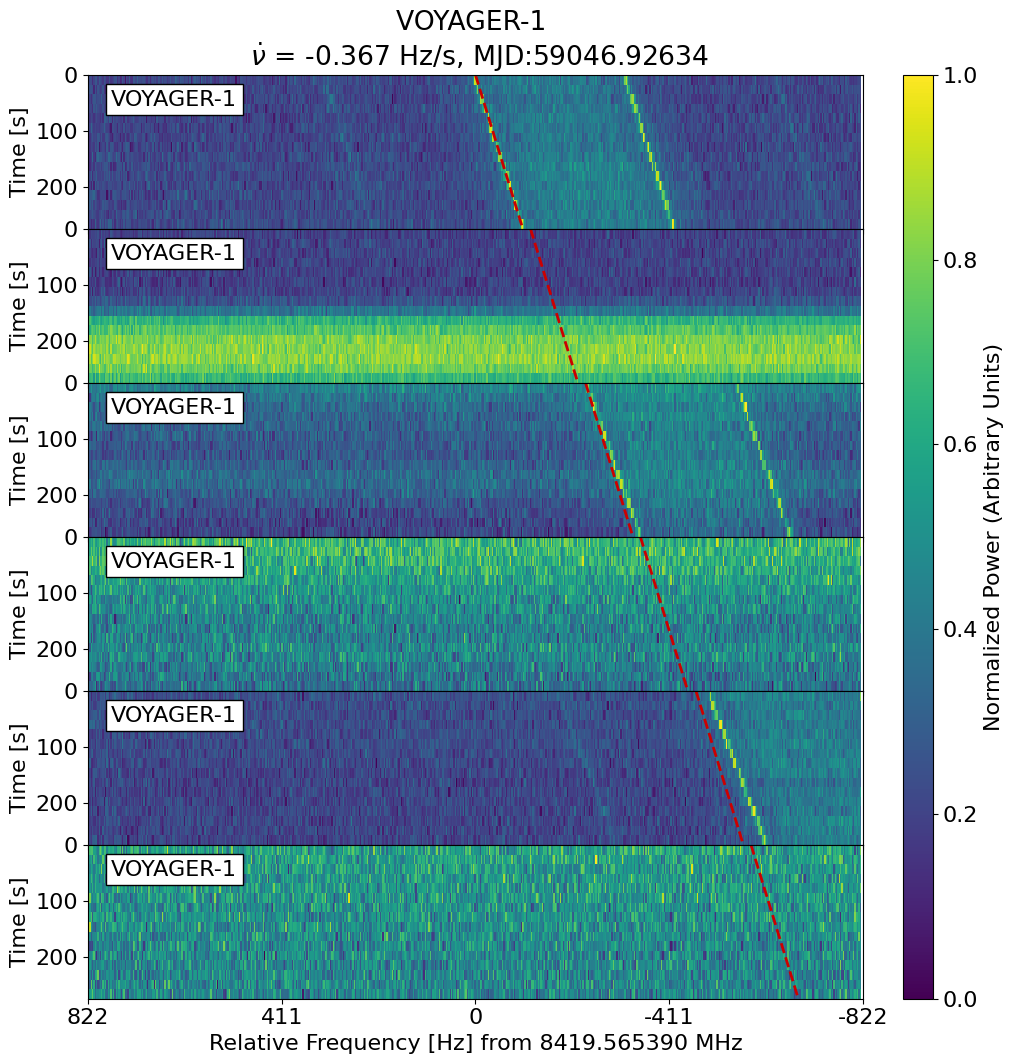

In [16]:
event2 = Image.open("voyager_2020_data/3_VOYAGER-1_dr_-0.37_freq_8419.564568.png")
event2